In [1]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
sys.path.append('..') 
import platform
import os
from pathlib import Path
import shutil
from pathlib import Path
import shutil
from utils.behavior.session_utils import load_session_df, parse_session_string
from utils.behavior.lick_analysis import clean_up_licks, parse_lick_trains
from scipy.io import loadmat
from itertools import chain
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.signal import find_peaks
from harp.clock import align_timestamps_to_anchor_points
from utils.basics.data_org import *
from utils.photometry.preprocessing import * 
from utils.photometry.plot_utils import align_signal_to_events, plot_FP_with_licks, color_gradient
import numpy as np
from scipy.signal import butter, filtfilt, medfilt
from scipy.optimize import curve_fit
import json
from sklearn.linear_model import LinearRegression
from matplotlib.gridspec import GridSpec
import pickle
# %matplotlib inline
# %matplotlib widget

In [2]:
session = 'm749472d20250108'
label = 'Gi'
session_dir = parse_session_string(session)
session_df, licks_L, licks_R = load_session_df(session)
licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
parsed_licks_L, _ = parse_lick_trains(licks_L)
parsed_licks_R, _ = parse_lick_trains(licks_R)
signal_region = load_session_FP(session, label, plot=False);
signal_region_raw = load_session_FP_raw(session, label, plot=False);

c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Region mPFC recorded at fiber 0
Region TH recorded at fiber 1
Region Gi recorded at fiber 2
Region mPFC recorded at fiber 0
Region TH recorded at fiber 1
Region Gi recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region TH recorded at fiber 1
Channel G:Region Gi recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region TH recorded at fiber 1
Channel Iso:Region Gi recorded at fiber 2


In [17]:
def plot_FP_with_licks_test(session, label, region):
    session_df, licks_L, licks_R = load_session_df(session)
    session_dir = parse_session_string(session)
    signal_region_prep = get_FP_data(session, label)
    get_FP_data(session, label)
    licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
    parsed_licks_L, _ = parse_lick_trains(licks_L)
    parsed_licks_R, _ = parse_lick_trains(licks_R)
    trial_starts = session_df['CSon']
    licks_in_trial_L = [train_start for train_start in list(parsed_licks_L['train_starts']) if any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    licks_in_trial_R = [train_start for train_start in list(parsed_licks_R['train_starts']) if any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    licks_out_trial_L = [train_start for train_start in list(parsed_licks_L['train_starts']) if not any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    licks_out_trial_R = [train_start for train_start in list(parsed_licks_R['train_starts']) if not any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    fig = plt.figure(figsize=(15, 8))
    colorL = 'b'
    colorR = 'r'
    all_channels = [key for key, value in signal_region_prep.items() if 'time' not in key]
    gs = GridSpec(len(all_channels), 5, figure=fig)
    for channel_id, channel in enumerate(all_channels):
        signal = signal_region_prep[channel][region]
        ax = fig.add_subplot(gs[channel_id, 0])
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], parsed_licks_L['train_starts'], ax = ax, legend = 'L', color = colorL)
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], parsed_licks_R['train_starts'], ax = ax, legend = 'R', color = colorR)
        ax.legend()
        ax.set_title(f'All licks')
        ax.set_ylabel(channel)
        # in vs out trial L
        ax = fig.add_subplot(gs[channel_id, 1])
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_in_trial_L, ax = ax, color = colorL, legend = 'in')
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_out_trial_L, ax = ax, color = colorR, legend = 'out')
        ax.legend()
        ax.set_title(f'In vs out trial L')
        # in vs out trial R
        ax = fig.add_subplot(gs[channel_id, 2])
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_in_trial_R, ax = ax, color = colorL, legend = 'in')     
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_out_trial_R, ax = ax, color = colorR, legend = 'out')
        ax.legend()
        ax.set_title(f'In vs out trial R')
        # in left, in vs out trial with gradient of lick lick peak
        ax = fig.add_subplot(gs[channel_id, 3])
        num_bins = 3
        peaks = parsed_licks_L['train_amps']
        colors_in = color_gradient([1, 0, 0], num_bins+1)
        colors_out = color_gradient([0, 0, 1], num_bins+1)
        edges = np.quantile(peaks, np.linspace(0, 1, num_bins+1))
        for ind in range(num_bins):
            mask = (peaks>edges[ind]) & (peaks<=edges[ind+1])
            if np.sum(mask)>2:
                align_signal_to_events(signal, signal_region_prep['time_in_beh'], np.array(parsed_licks_L['train_starts'])[mask], ax = ax, color = colors_in[ind+1], legend = f'In trial bin {ind}', plot_error=False)
        ax.set_title(f'Left licks by lick peak')
        # in right, in vs out trial with gradient of lick lick peak\
        ax = fig.add_subplot(gs[channel_id, 4])
        peaks = parsed_licks_R['train_amps']
        colors_in = color_gradient([0, 0, 1], num_bins+1)
        colors_out = color_gradient([0, 0, 1], num_bins+1)
        edges = np.quantile(peaks, np.linspace(0, 1, num_bins+1))
        for ind in range(num_bins):
            mask = (peaks>edges[ind]) & (peaks<=edges[ind+1])
            if np.sum(mask)>2:
                align_signal_to_events(signal, signal_region_prep['time_in_beh'], np.array(parsed_licks_R['train_starts'])[mask], ax = ax, color = colors_in[ind+1], legend = f'In trial bin {ind}', plot_error=False)  
        ax.set_title(f'Right licks by lick peak')

    plt.tight_layout()
    fig.suptitle(f'{session}_{region}')
    fig.savefig(os.path.join(session_dir['saveFigFolder'], f'{session}_{region}_FP_licks.pdf'))

F:\\749472\m749472d20250108\sorted\session\m749472d20250108_FP_Gi.pkl
F:\\749472\m749472d20250108\sorted\session\m749472d20250108_FP_Gi.pkl


c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


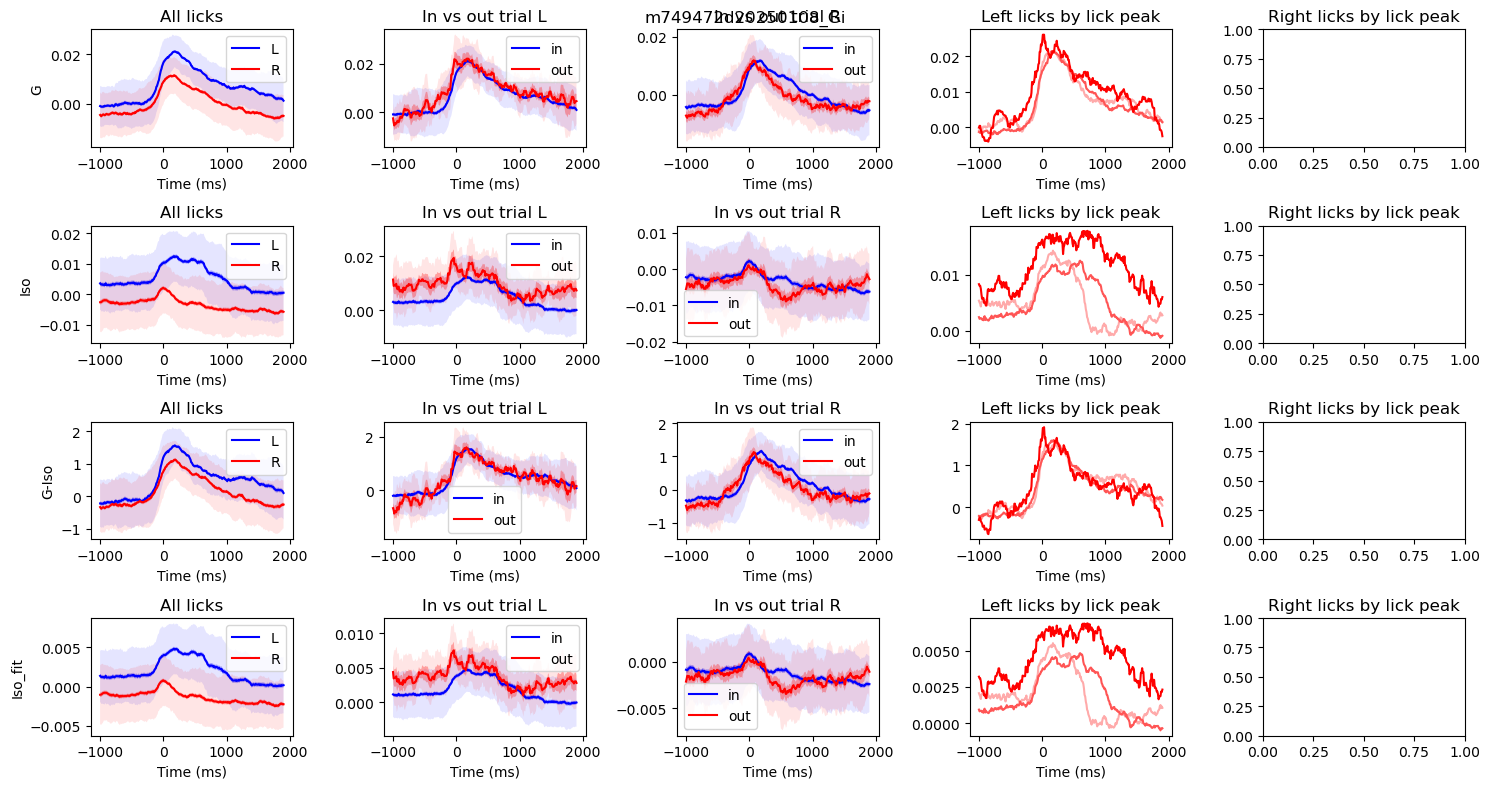

In [18]:
plot_FP_with_licks_test(session, label, 'Gi')  

In [7]:
session_list = get_session_list('photometry_Gi', '749472', 'good_beh')

In [17]:
session_list = get_session_list('photometry', 'all', 'crusIgood')

In [ ]:
session_list = get_session_list('photometry', 'all', 'crusIgood')

In [18]:
tmp_dict = {"0": "mPFC", "1":"LCN", "2":"LC"}

In [19]:
tmp_dict

{'0': 'mPFC', '1': 'CrusI', '2': 'LC'}

In [20]:
for session in session_list:
    session_dir = parse_session_string(session)
    # write tmp_dict to json
    with open(os.path.join(session_dir['photometryPath'], f'{session}.json'), 'w') as f:
        json.dump(tmp_dict, f)
    print(f"Finished writing {session}.json")

Finished writing m699461d20231217.json
Finished writing m699461d20231218.json
Finished writing m699461d20231219.json
Finished writing m699461d20231220.json
Finished writing m699461d20231222.json
Finished writing m699461d20240102.json
Finished writing m699461d20240103.json
Finished writing m699461d20240104.json
Finished writing m699461d20240105.json
Finished writing m699461d20240106.json
Finished writing m699461d20240107.json
Finished writing m699461d20240116.json
Finished writing m699461d20240117.json
Finished writing m699462d20240103.json
Finished writing m699462d20240104.json
Finished writing m699462d20240106.json
Finished writing m699462d20240107.json
Finished writing m699462d20240108.json
Finished writing m699462d20240109.json
Finished writing m699462d20240111.json
Finished writing m699462d20240112.json
Finished writing m699462d20240113.json
Finished writing m699462d20240114.json
Finished writing m699462d20240116.json
Finished writing m699462d20240117.json
Finished writing m699472d